In [4]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')


In [6]:
# Feature Engineering
# Aggregate transaction data for each customer
transaction_summary = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Price': 'mean'
}).reset_index()

In [7]:
# Merge customer data with transaction summary
merged_data = pd.merge(customers, transaction_summary, on='CustomerID', how='left')

# Handle missing values by replacing NaN with 0
merged_data.fillna(0, inplace=True)



In [8]:
# Select relevant features for clustering
features = merged_data[['TotalValue', 'Quantity', 'Price', 'Region']]

# One-hot encode categorical data (e.g., Region)
features = pd.get_dummies(features, columns=['Region'], drop_first=True)



In [9]:
# Normalize numerical features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)


In [10]:
# Apply KMeans clustering (exploring clusters between 2 and 10)
best_db_index = float('inf')
best_n_clusters = None
best_kmeans_model = None

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(normalized_features)
    db_index = davies_bouldin_score(normalized_features, labels)
    
    if db_index < best_db_index:
        best_db_index = db_index
        best_n_clusters = n_clusters
        best_kmeans_model = kmeans


In [11]:
# Assign best clustering results to the dataset
merged_data['Cluster'] = best_kmeans_model.labels_

In [12]:
# Compute Silhouette Score for additional evaluation
silhouette_avg = silhouette_score(normalized_features, merged_data['Cluster'])

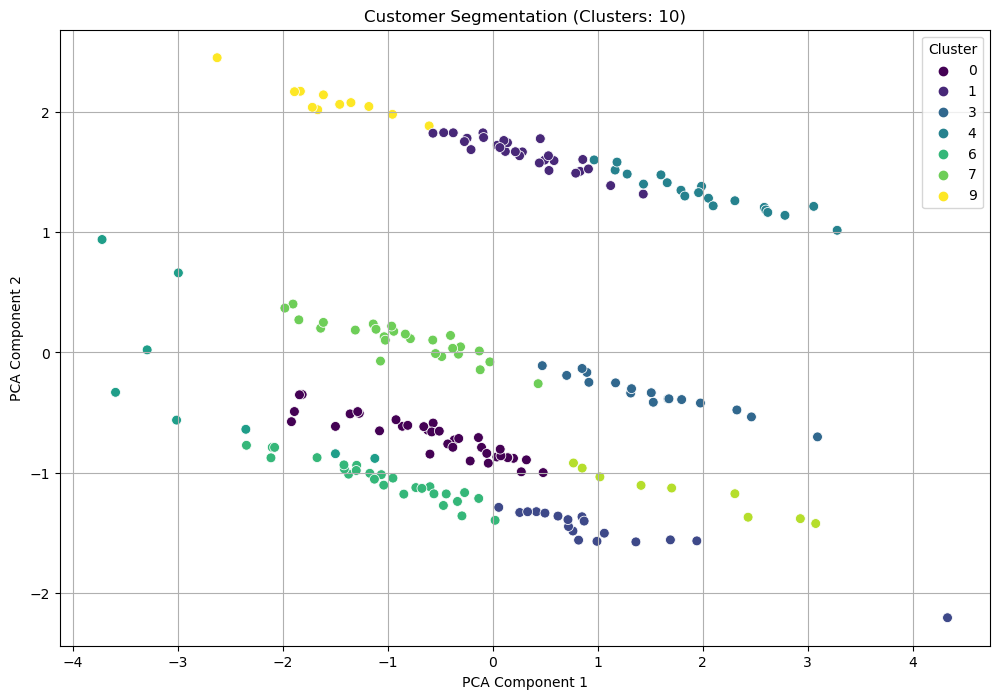

In [13]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_features)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=reduced_data[:, 0], 
    y=reduced_data[:, 1], 
    hue=merged_data['Cluster'], 
    palette='viridis',
    s=50
)
plt.title(f'Customer Segmentation (Clusters: {best_n_clusters})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.show()

In [14]:
# Save clustering results to CSV
merged_data.to_csv('Customer_Segmentation_Results.csv', index=False)

# Print Clustering Metrics
print(f"Optimal Number of Clusters: {best_n_clusters}")
print(f"Davies-Bouldin Index: {best_db_index:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")

Optimal Number of Clusters: 10
Davies-Bouldin Index: 0.8983
Silhouette Score: 0.3801
